<a href="https://colab.research.google.com/github/ronald-hk-chung/ssnotebook/blob/main/basics_of_neural_network/understanding_stochastic_gradient_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding Stochastic Gradient Descent

> Gradient descent is a method for unconstrained mathematical optimization. It is a first-order iterative algorithm for finding a local minimum of a differentiable multivariate function.<sup>[1]</sup>

The idea is to take repeated steps in the opposite direction of the gradient of the function at the current point (because this is the direction of steepest descent) to achieve the best possible set of parameters / coefficients for a given model, data points to find the local minimum of a loss function.

A simple extension of gradient descent, stochastic gradient descent, serves as the most basic algorithm used for training most deep networks today.

Reference:

1. https://en.wikipedia.org/wiki/Gradient_descent

## Steps of Stochastic Gradient Descent (SGD)

0. Define the model for the problem
1. Initialize the weights.
2. Make predictions using the model with initialised weights
3. Compute the Loss
4. Compute the Gradients
5. *Step* to Update the parameters
6. Go back to the step 2, and *repeat* the process.
7. Iterate until you decide to *stop* the training process (for instance, because the model is good enough or you don't want to wait any longer).

<img src="https://github.com/ronald-hk-chung/ssnotebook/blob/main/basics_of_neural_network/assets/steps_of_SGD.jpg?raw=true">

## Defining a simple scalar function

$y = w \times X + b + noise$

> Note: noise is added to the scalar function for synthetic data generation

## Generate Synthetic data and split into training and valid dataset

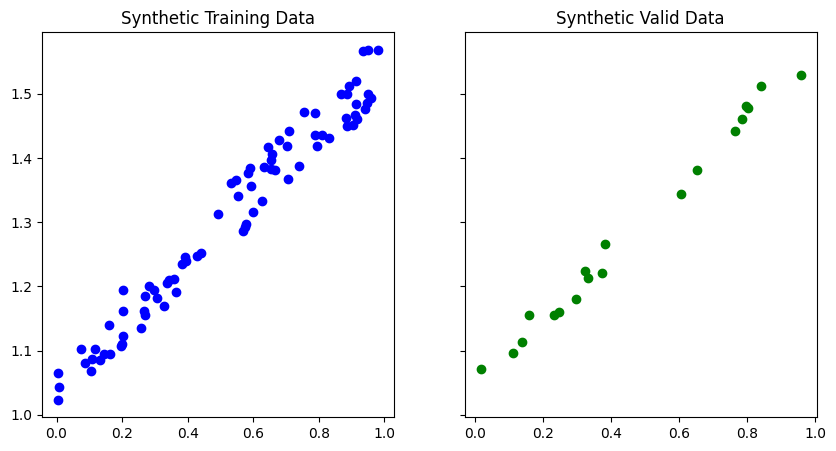

In [ ]:
import torch
import matplotlib.pyplot as plt

# To ensure reproducibility
torch.manual_seed(42)

# Generating synthetic data
X = torch.rand(100) # random numbers from a uniform distribution on the interval (0, 1)
w_true, b_true = 0.5, 1
noise = torch.rand(100) * 0.1
y = w_true * X + b_true + noise

# Using 80:20 training and valid data split
X_train, y_train = X[:80], y[:80]
X_valid, y_valid = X[81:100], y[81:100]

# Plot synthetic data
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10,5))
ax1.scatter(X_train, y_train, color="b")
ax1.set_title("Synthetic Training Data")
ax2.scatter(X_valid, y_valid, color='g')
ax2.set_title("Synthetic Valid Data");

## Step 0 - Define a model for the problem

We define a function / model `model` which is a scalar function for the regression problem (same as the syntehtic data generations without noise)

In [ ]:
# Define function f to predict
def model(X, params):
    w, b = params
    return w * X + b

## Step 1 - Initialize the weights

For training a model, we need to randomly initialize the parameters / weights, in this case, we need to initialise w1, w2, and b from a scalar function model.

Tensor for training data requires the computation of its gradients, which is what the `requires_grad=True` argument is good for.


In [ ]:
# generate parameters from random numbers from a normal distribution with mean 0 and variance 1
params = torch.randn(2, requires_grad=True, dtype=torch.float)
orig_params = params.clone()
# b = torch.randn(1, requires_grad=True, dtype=torch.float)
print(params) # w, b

tensor([-0.6430,  0.7113], requires_grad=True)


## Step 2 - Make predictions using the model with initialised weights

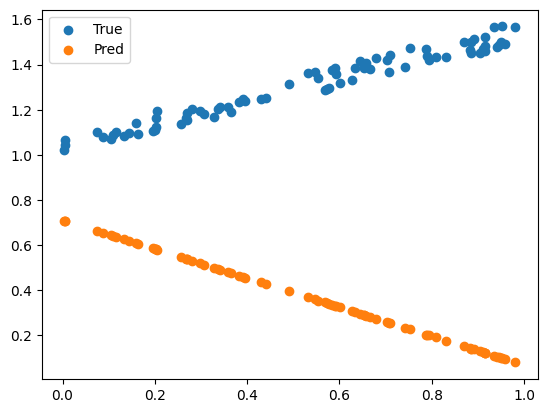

In [ ]:
# Make predictions using the model with initialised random weights
y_preds = model(X_train, params)

# Plot out the prediction vs. true label
fig, ax = plt.subplots()
ax.scatter(X_train, y_train, label='True')
ax.scatter(X_train, y_preds.detach().cpu(), label='Pred')
ax.legend();

## Step 3 - Compute the Loss

For a regression problem, the loss is given by the **Mean Square Error (MSE)**

$MSE=\frac{1}{N} \sum_{i=1}^N\left(y_i-\hat{y}_i\right)^2$

 that is, the average of all squared differences labels $y$ and predictions. $w_1 \times X^2 + w_2 \times X + b$:

> Add blockquote





In [ ]:
# define loss function (MSE - Mean Squared Error)
def mse(preds, targets):
  return ((preds - targets)**2).mean()

In [ ]:
# Calculate Loss
loss = mse(y_preds, y_train)
print(f'Loss: {loss.item()}')

Loss: 0.9970607757568359


## Step 4 - Compute the Gradients

A graident is a **partial derivative** where it tells you how much a given quantity changes when there is a slight variation with respect to the **single parameter**

$
\begin{gathered}
\frac{\partial MSE}{\partial b}=\frac{\partial MSE}{\partial \hat{y}_i} \cdot \frac{\partial \hat{y}_i}{\partial b}=\frac{1}{N} \sum_{i=1}^N 2\left(y_i-b-w x_i\right) \cdot(-1)=-2 \frac{1}{N} \sum_{i=1}^N\left(y_i-\hat{y}_i\right) \\
\frac{\partial M S E}{\partial w}=\frac{\partial M S E}{\partial \hat{y}_i} \cdot \frac{\partial \hat{y}_i}{\partial }=\frac{1}{N} \sum_{i=1}^N 2\left(y_i-b-w x_i\right) \cdot\left(-x_i\right)=-2 \frac{1}{N} \sum_{i=1}^N x_i\left(y_i-\hat{y}_i\right)
\end{gathered}
$

**Autograd** is PyTorch's automatic differentiaion package. With **Autograd**, we can compute the partial derivatives of the **loss** w.r.t. our parameters by invoking `backward()` method from the corresponding Python variable -> `loss.backward()`

`grad` attribute can be used to inspect the actual values of the gradients w.r.t. the parameter, e.g. `w.grad`

Note that the gradients are accumulated everytime `backward()` is called, we need to zero the grade by setting `parameter.grad = None`



In [ ]:
# Manual computation of gradients
b_grad = -2 * (y_preds - y_train).mean()
w_grad = -2 * (X_train * (y_preds - y_train)).mean()
print(w_grad, b_grad)

tensor(1.1966, grad_fn=<MulBackward0>) tensor(1.8782, grad_fn=<MulBackward0>)


In [ ]:
# computation using autograd
loss.backward()
print(params.grad)

tensor([-1.1966, -1.8782])


## Step 5 - `step()` to Update the parameters

Use the gradients to update hte parameters, we reverse the sign for the gradient for hte update to minimize the `loss` the learning rate $\eta$ is a multiplicative factor that need to be applied to the gradient for the parameter update.

$\begin{aligned} & w=w-\eta \frac{\partial MSE}{\partial w} \\ & b=b-\eta \frac{\partial MSE}{\partial b}\end{aligned}$

In [ ]:
# Step for Gradient descent
lr = 0.1
params.data -= lr * params.grad
params.grad = None

Old loss: 0.9970607757568359
New loss: 0.5655620694160461


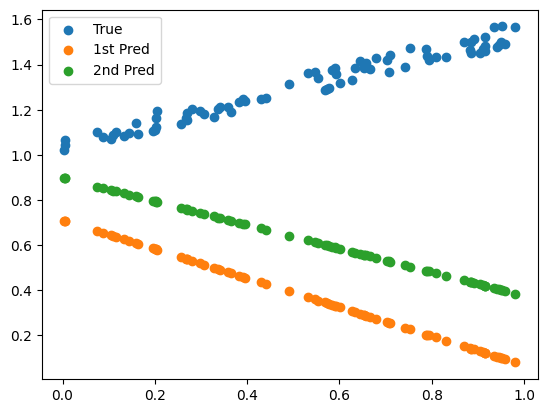

In [ ]:
# Make new prediction
y_preds_orig = y_preds.clone()
y_preds = model(X_train, params)
print(f'Old loss: {mse(y_preds_orig, y_train)}')
print(f'New loss: {mse(y_preds, y_train)}')

# Plot the result
fig, ax = plt.subplots()
ax.scatter(X_train, y_train, label='True')
ax.scatter(X_train, y_preds_orig.detach().cpu(), label='1st Pred')
ax.scatter(X_train, y_preds.detach().cpu(), label='2nd Pred')
ax.legend();

##Step 6 - Go back to the step 2, and *repeat* the process.

Using the updated parameters to go back to Step 2, restart the process

> An epoch is complete whenever every point has been already used for computing the loss. For batch gradient descent, this is trivial, as it uses all points for computing the loss — one epoch is the same as one update. For stochastic gradient descent, one epoch means N updates, while for mini-batch (of size n), one epoch has N/n updates.

In [308]:
lr = 0.1
n_epochs = 20

# Step 1 - Initialize the weights
params = torch.randn(2, requires_grad=True, dtype=torch.float)

for epoch in range(n_epochs):
    # Step 2 - Make predictions using the model
    y_preds = model(X_train, params)
    # Step 3 - Compute the Loss
    loss = mse(y_preds, y_train)
    # Step 4 - Compute the Gradients
    loss.backward()
    # Step 5 - `step()` to Update the parameters and zero grad as loss is cumulative
    params.data -= lr * params.grad
    params.grad = None
    print(f'MSE Loss: {loss.item()} | Params: {params.data})')

MSE Loss: 1.3635965585708618 | Params: tensor([0.1427, 0.3763]))
MSE Loss: 0.7460799217224121 | Params: tensor([0.2400, 0.5476]))
MSE Loss: 0.4083805978298187 | Params: tensor([0.3120, 0.6743]))
MSE Loss: 0.2237040102481842 | Params: tensor([0.3652, 0.7680]))
MSE Loss: 0.1227104440331459 | Params: tensor([0.4046, 0.8373]))
MSE Loss: 0.06748040020465851 | Params: tensor([0.4336, 0.8886]))
MSE Loss: 0.03727688640356064 | Params: tensor([0.4551, 0.9265]))
MSE Loss: 0.02075955644249916 | Params: tensor([0.4710, 0.9546]))
MSE Loss: 0.011726738885045052 | Params: tensor([0.4827, 0.9753]))
MSE Loss: 0.006786947138607502 | Params: tensor([0.4913, 0.9907]))
MSE Loss: 0.004085508640855551 | Params: tensor([0.4977, 1.0020]))
MSE Loss: 0.0026081495452672243 | Params: tensor([0.5024, 1.0105]))
MSE Loss: 0.0018002006690949202 | Params: tensor([0.5058, 1.0167]))
MSE Loss: 0.0013583265244960785 | Params: tensor([0.5084, 1.0213]))
MSE Loss: 0.0011166502954438329 | Params: tensor([0.5102, 1.0247]))
MSE 

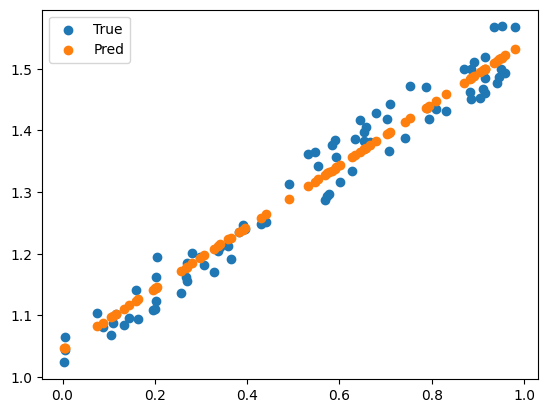

In [299]:
# Plot the result
fig, ax = plt.subplots()
ax.scatter(X_train, y_train, label='True')
ax.scatter(X_train, y_preds.detach().cpu(), label='Pred')
ax.legend();

## Optimizer - Basic Setup

PyTorch opimitzers (like **SGD** or **Adam**) takes the parameters we want to update, the learning rate we want to use and performs the updates through its `step()` method. This replaces the manual updating of parameters in the training loop


In [309]:
class BasicOptim:
  def __init__(self, params, lr):
    self.params = params

  def step(self, *args, **kwargs):
    self.params.data -= self.lr * self.params.grad

  def zero_grad(self, *args, **kwargs):
    self.params.grad = None

## A Typical Training/Validation Loop

With all above setup, we can define a typical Training and Validation loop for our regression problem

In PyTorch, a model is represented by a regular Python class that inherits `nn.Module`

`__init__(self)`: defines the parts that make up the model (parameters)

`forward(self)`: defines the actual computation which outputs the prediction.

> forward(x) method should not be called directly. You should call the whole model itself, as in model(x) to perform a forward pass and output predictions.

In [380]:
import torch
import torch.nn as nn

class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.w = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))
        self.b = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float))

    def forward(self, X):
        return self.w * X + self.b

custom_model = RegressionModel()

In [381]:
class BasicOptim:
  def __init__(self, params, lr):
    self.params = list(params)
    self.lr = lr

  def step(self):
    for p in self.params:
        p.data -= self.lr * p.grad

  def zero_grad(self, *args, **kwargs):
    for p in self.params:
        p.grad = None

custom_optimizer = BasicOptim(params=custom_model.parameters(), lr=0.2)

In [386]:
n_epochs = 100

def train_step(X, y):
    # Sets model to TRAIN mode
    custom_model.train()
    # Makes predictions
    y_preds = custom_model(X)
    # Computes loss
    loss = mse(y_preds, y)
    # Computes gradients
    loss.backward()
    # Updates parameters and zeroes gradients
    custom_optimizer.step()
    custom_optimizer.zero_grad()
    return loss

for epoch in range(n_epochs):
    train_step(X_train, y_train)

print(custom_model.state_dict())

OrderedDict([('w', tensor([0.5102])), ('b', tensor([1.0375]))])
